# FairPredictor XGBoost Examples
This file contains demo code for an extended version of the example in Readme.md (additionally handling more fairness over multiple groups),  and enforcing a range of fairness definition on COMPAS.

It is a modified version of [quickstart_autogluon.ipynb](quickstart_autogluon.ipynb)

FairPredictor is a postprocessing approach for enforcing fairness, with support for a wide range of performance metrics and fairness criteria, and support for inferred attributes, i.e. it does not require access to protected attributes at test time. 
Under the hood, FairPredictor works by adjusting the decision boundary for each group individually. Where groups are not available, it makes use of inferred group membership to adjust decision boundaries.

The key idea underlying this toolkit is that for a wide range of use cases, the most suitable classifier should do more than maximize some form of accuracy.
We offer a general toolkit that allows different measures to be optimized and additional constraints to be imposed by tuning the behavior of a binary predictor on validation data.

For example, classifiers can be tuned to maximize performance for a wide range of metrics such as:

* Accuracy
* Balanced Accuracy
* F1 score
* MCC
* Custom utility functions

While also approximately satisfying a wide range of group constraints such as:

* Demographic Parity (The idea that positive decisions should occur at the same rates for all protected groups, for example for men at the same rate as for women)
* Equal Opportunity (The recall should be the same for all protected groups)
* Minimum recall constraints (The recall should be above a particular level for all groups)
* Minimum Precision constraints (The precision should be above a particular level for all groups)
* Custom Fairness Metrics

The full set of constraints and objectives can be seen in Readme.md 

In [1]:
# Load and train a baseline classifier

from oxonfair import dataset_loader, FairPredictor
from oxonfair import group_metrics as gm
import xgboost
import pandas as pd
import numpy as np


train_data, val_data, test_data = dataset_loader.adult('sex')
predictor=xgboost.XGBClassifier().fit(X=train_data['data'],y=train_data['target'])

/opt/miniconda3/envs/ag/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_data['data'].shape,val_data['data'].shape,test_data['data'].shape

((24421, 14), (12210, 14), (12211, 14))

In [3]:
# Modify predictor to enforce fairness over the val_data with respect to groups given by the column 'sex'
fpredictor = FairPredictor(predictor,train_data, 'sex')
# Maximize accuracy while enforcing that the demographic parity (the difference in positive decision rates between men and women is at most 0.02)
fpredictor.fit(gm.accuracy,gm.demographic_parity,0.02)


Groups passed twice to fairpredictor both as part of the dataset and as an argument. The argument will be used.


In [4]:
# Evaluate on test data
fpredictor.predict(test_data)

array([0, 0, 0, ..., 0, 0, 0])

In [5]:
# Evaluate a range of performance measures, and compare against original classifier on test data
fpredictor.evaluate(test_data, verbose=True)

,original,updated
Accuracy,0.872164,0.852510
Balanced Accuracy,0.799977,0.751872
F1 score,0.712364,0.644563
MCC,0.633898,0.564798
Precision,0.771657,0.761305
Recall,0.661533,0.558864
ROC AUC,0.928449,0.822116


In [6]:
# Evaluate against a range of standard fairness definitions and compare against original classifier on test data
fpredictor.evaluate_fairness(test_data, verbose=True)

,original,updated
Statistical Parity,0.180490,0.004832
Predictive Parity,0.023388,0.340631
Equal Opportunity,0.094358,0.330496
Average Group Difference in False Negative Rate,0.094358,0.330496
Equalized Odds,0.078240,0.194312
Conditional Use Accuracy,0.053734,0.250397
Average Group Difference in Accuracy,0.091453,0.073553
Treatment Equality,0.146262,4.453745


In [7]:
# Evaluate a range of performance measures per group, and compare against original classifier on test data
fpredictor.evaluate_groups(test_data, verbose=True, return_original=True)

Accuracy  Balanced Accuracy  F1 score       MCC  \
         Groups                                                                
original Overall             0.872164           0.799977  0.712364  0.633898   
         0                   0.933300           0.778938  0.655612  0.625599   
         1                   0.841847           0.795056  0.721947  0.614958   
         Maximum difference  0.091453           0.016118  0.066335  0.010641   
updated  Overall             0.852510           0.751872  0.644563  0.564798   
         0                   0.901680           0.874342  0.650877  0.618120   
         1                   0.828127           0.738159  0.642730  0.573617   
         Maximum difference  0.073553           0.136183  0.008147  0.044503   

                             Precision    Recall   ROC AUC  Positive Count  \
         Groups                                                              
original Overall              0.771657  0.661533  0.928449          2922.0   
         0                    0.751462  0.581448  0.946810           442.0   
         1                    0.774850  0.675806  0.910547          2480.0   
         Maximum difference   0.023388  0.094358  0.036263          2038.0   
updated  Overall              0.761305  0.558864  0.822116          2922.0   
         0                    0.531519  0.839367  0.946810           442.0   
         1                    0.872149  0.508871  0.910547          2480.0   
         Maximum difference   0.340631  0.330496  0.036263          2038.0   

                             Negative Count  Positive Label Rate  \
         Groups                                                    
original Overall                     9289.0             0.239292   
         0                           3606.0             0.109190   
         1                           5683.0             0.303810   
         Maximum difference          2077.0             0.194620   
updated  Overall                     9289.0             0.239292   
         0                           3606.0             0.109190   
         1                           5683.0             0.303810   
         Maximum difference          2077.0             0.194620   

                             Positive Prediction Rate  
         Groups                                        
original Overall                             0.205143  
         0                                   0.084486  
         1                                   0.264976  
         Maximum difference                  0.180490  
updated  Overall                             0.175661  
         0                                   0.172431  
         1                                   0.177263  
         Maximum difference                  0.004832

In [8]:
train_data, val_data, test_data = dataset_loader.adult('sex')
predictor=xgboost.XGBClassifier().fit(X=train_data['data'],y=train_data['target'])


In [9]:
fpredictor = FairPredictor(predictor,val_data,'race') 
# Maximize accuracy while enforcing that the demographic parity (the difference in positive decision rates between men and women is at most 0.02)
fpredictor.fit(gm.accuracy, gm.demographic_parity, .02)

Groups passed twice to fairpredictor both as part of the dataset and as an argument. The argument will be used.


In [10]:
# Unlike the previous case, we find that demographic parity is still high on test data, although it is improved.
fpredictor.evaluate_fairness(test_data)

,original,updated
Statistical Parity,0.092993,0.074443
Predictive Parity,0.064486,0.173749
Equal Opportunity,0.149332,0.176780
Average Group Difference in False Negative Rate,0.149332,0.176780
Equalized Odds,0.087968,0.103295
Conditional Use Accuracy,0.061980,0.125346
Average Group Difference in Accuracy,0.057213,0.043561
Treatment Equality,1.008716,5.134823


In [11]:
fpredictor.evaluate_fairness()

,original,updated
Statistical Parity,0.086590,0.019697
Predictive Parity,0.233008,0.292160
Equal Opportunity,0.045345,0.148495
Average Group Difference in False Negative Rate,0.045345,0.148495
Equalized Odds,0.040168,0.095018
Conditional Use Accuracy,0.139236,0.174533
Average Group Difference in Accuracy,0.050472,0.037915
Treatment Equality,0.714552,2.669082


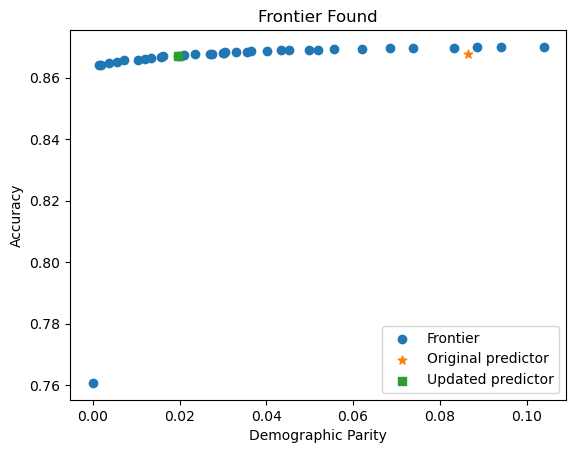

In [12]:
#To debug this, we can look at the Pareto Frontier of solutions considered, on the validation set
fpredictor.plot_frontier() 

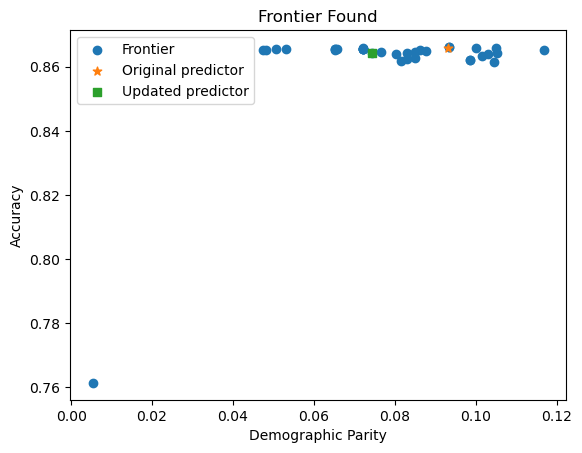

In [13]:
#and on the test set
fpredictor.plot_frontier(test_data) 

In [14]:
#We find that the demographic parity is very different on test data for a range of solutions found.
#By looking at the per group decomposition, we can find out why.
fpredictor.evaluate_groups(test_data)

Accuracy  Balanced Accuracy  F1 score       MCC  \
         Groups                                                                
original Overall             0.865941           0.791664  0.698582  0.615966   
         0                   0.872340           0.738732  0.600000  0.532348   
         1                   0.851541           0.804440  0.736318  0.637235   
         2                   0.927773           0.782429  0.652893  0.616809   
         3                   0.960000           0.912442  0.750000  0.735431   
         4                   0.858626           0.789908  0.699717  0.610908   
         Maximum difference  0.108459           0.173711  0.150000  0.203082   
updated  Overall             0.864303           0.783316  0.688943  0.607886   
         0                   0.882979           0.905653  0.744186  0.698093   
         1                   0.834734           0.774041  0.694301  0.591102   
         2                   0.907137           0.855902  0.660377  0.619369   
         3                   0.920000           0.890937  0.600000  0.593193   
         4                   0.859865           0.779789  0.690511  0.608630   
         Maximum difference  0.085266           0.131613  0.144186  0.106991   

                             Precision    Recall   ROC AUC  Positive Count  \
         Groups                                                              
original Overall              0.756078  0.649213  0.922685          2922.0   
         0                    0.692308  0.529412  0.952636            17.0   
         1                    0.795699  0.685185  0.920051           108.0   
         2                    0.724771  0.593985  0.944594           133.0   
         3                    0.666667  0.857143  0.938556             7.0   
         4                    0.756674  0.650734  0.918673          2657.0   
         Maximum difference   0.129032  0.327731  0.033962          2650.0   
updated  Overall              0.762994  0.627995  0.902943          2922.0   
         0                    0.615385  0.941176  0.952636            17.0   
         1                    0.788235  0.620370  0.920051           108.0   
         2                    0.567568  0.789474  0.944594           133.0   
         3                    0.461538  0.857143  0.938556             7.0   
         4                    0.782920  0.617614  0.918673          2657.0   
         Maximum difference   0.326697  0.323563  0.033962          2650.0   

                             Negative Count  Positive Label Rate  \
         Groups                                                    
original Overall                     9289.0             0.239292   
         0                             77.0             0.180851   
         1                            249.0             0.302521   
         2                           1030.0             0.114359   
         3                             93.0             0.070000   
         4                           7840.0             0.253120   
         Maximum difference          7763.0             0.232521   
updated  Overall                     9289.0             0.239292   
         0                             77.0             0.180851   
         1                            249.0             0.302521   
         2                           1030.0             0.114359   
         3                             93.0             0.070000   
         4                           7840.0             0.253120   
         Maximum difference          7763.0             0.232521   

                             Positive Prediction Rate  
         Groups                                        
original Overall                             0.205470  
         0                                   0.138298  
         1                                   0.260504  
         2                                   0.093723  
         3                                   0.090000  
         4        

In [15]:
#The groups with the smallest Positive Prediction Rate (corresponding to American-Indian-Eskimo, and Asian-Pacific-Islander) 
# only have around 100 samples making it impossible to accurately evaluate demographic parity, while the
# group labelled 'Other' has even less data.
# Moreover, on validation data we find that there are less than 90 people identified as American-Indian-Eskimo, 
# meaning that it is not possible to predict if the positive prediction rate will hold on new data. 
fpredictor.evaluate_groups()

Accuracy  Balanced Accuracy  F1 score       MCC  \
         Groups                                                                
original Overall             0.867649           0.793729  0.702175  0.620785   
         0                   0.934426           0.763975  0.500000  0.469711   
         1                   0.876033           0.794547  0.705882  0.633181   
         2                   0.929371           0.795517  0.698529  0.667782   
         3                   0.955752           0.791667  0.736842  0.745532   
         4                   0.858769           0.791750  0.702779  0.613605   
         Maximum difference  0.096983           0.031542  0.236842  0.275821   
updated  Overall             0.867076           0.784791  0.693021  0.614942   
         0                   0.852459           0.720497  0.307692  0.282836   
         1                   0.876033           0.782066  0.693878  0.628191   
         2                   0.925926           0.883579  0.748538  0.709822   
         3                   0.902655           0.872112  0.645161  0.613076   
         4                   0.860013           0.779496  0.691415  0.610483   
         Maximum difference  0.073467           0.163082  0.440846  0.426986   

                             Precision    Recall   ROC AUC  Positive Count  \
         Groups                                                              
original Overall              0.760783  0.651951  0.924542          2922.0   
         0                    0.444444  0.571429  0.893168             7.0   
         1                    0.782609  0.642857  0.919013            84.0   
         2                    0.811966  0.612903  0.958167           155.0   
         3                    1.000000  0.583333  0.931518            12.0   
         4                    0.758036  0.655030  0.919732          2664.0   
         Maximum difference   0.555556  0.083601  0.064999          2657.0   
updated  Overall              0.774630  0.626968  0.905492          2922.0   
         0                    0.210526  0.571429  0.893168             7.0   
         1                    0.809524  0.607143  0.919013            84.0   
         2                    0.684492  0.825806  0.958167           155.0   
         3                    0.526316  0.833333  0.931518            12.0   
         4                    0.789119  0.615240  0.919732          2664.0   
         Maximum difference   0.598997  0.261905  0.064999          2657.0   

                             Negative Count  Positive Label Rate  \
         Groups                                                    
original Overall                     9288.0             0.239312   
         0                            115.0             0.057377   
         1                            279.0             0.231405   
         2                           1006.0             0.133506   
         3                            101.0             0.106195   
         4                           7787.0             0.254904   
         Maximum difference          7686.0             0.197527   
updated  Overall                     9288.0             0.239312   
         0                            115.0             0.057377   
         1                            279.0             0.231405   
         2                           1006.0             0.133506   
         3                            101.0             0.106195   
         4                           7787.0             0.254904   
         Maximum difference          7686.0             0.197527   

                             Positive Prediction Rate  
         Groups                                        
original Overall                             0.205078  
         0                                   0.073770  
         1                                   0.190083  
         2                                   0.100775  
         3                                   0.061947  
         4        

## Fairness on COMPAS using Inferred Attributes

We demonstrate how to enforce a wide range of fairness definitions on the COMPAS dataset. This dataset records paroles caught violating the terms of parole. As it measures who was caught, it is strongly influenced by policing and environmental biases, and should not be confused with a measurement of who actually violated their terms of parole. See [this paper](https://datasets-benchmarks-proceedings.neurips.cc/paper/2021/file/92cc227532d17e56e07902b254dfad10-Paper-round1.pdf) for a discussion of its limitations and caveats. 
We use it because it is a standard fairness dataset that captures such strong differences in outcome between people identified as African-American and everyone else, that classifiers trained on this dataset violate most definitions of fairness.

As many of the ethnic groups are too small for reliable statistical estimation, we only consider differences is in outcomes between African-Americans vs. everyone else (labeled as other).
We load and preprocess the COMPAS dataset, splitting it into three roughly equal partitions of train, validation, and test:

In [16]:
#Generate two sets of training, validation and test, with race and without.
train, val, test = dataset_loader.compas('race', train_proportion=0.66, test_proportion=0.33, discard_groups=True, replace_groups={'Hispanic':'Other', 'Native American':'Other', 'Asian':'Other'})
train_g, val_g, test_g = dataset_loader.compas('race', train_proportion=0.66, test_proportion=0.33, replace_groups={'Hispanic':'Other', 'Native American':'Other', 'Asian':'Other'})

In [17]:
predictor = xgboost.XGBClassifier().fit(X=train_g['data'],y=train_g['target'])
predictor2 = xgboost.XGBClassifier().fit(X=train['data'],y=train['target'])
protected = xgboost.XGBClassifier().fit(X=train['data'],y=2*(train['groups']=='Other')+(train['groups']=='Caucasian'))

In [18]:
fpredictor=FairPredictor(predictor2, train, inferred_groups=protected)
fpredictor.fit(gm.accuracy, gm.demographic_parity, 0.025)

In [19]:
#However, instead we will show how a family of fairness measures can be individually optimized. 
# The following code plots a table showing the change in accuracy and the fairness measure on a held-out test set as we decrease
# the fairness measure to less than 0.025 for all measures except for disparate impact which we raise to above 0.975.
# We define a helper function for evaluation:

def evaluate(fpredictor, use_metrics, test):
    "Print a table showing the accuracy drop that comes with enforcing fairness"
    extra_metrics= {**use_metrics, 'accuracy':gm.accuracy}
    collect=pd.DataFrame(columns=['Measure (original)', 'Measure (updated)', 'Accuracy (original)', 'Accuracy (updated)'])
    for d in use_metrics.items():
        if d[1].greater_is_better is False:
            fpredictor.fit(gm.accuracy,d[1], 0.025)
        else:
            fpredictor.fit(gm.accuracy,d[1], 1-0.025)
        tmp=fpredictor.evaluate_fairness(test,metrics=extra_metrics)
        collect.loc[d[1].name]=np.concatenate((np.asarray(tmp.loc[d[1].name]), np.asarray(tmp.loc[gm.accuracy.name])), 0)
    return collect

In [20]:
train['data'].columns

Index(['sex', 'age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count',
       'priors_count', 'age_cat', 'c_charge_degree'],
      dtype='object')

In [21]:
#We can now contrast the behavior of a fair classifier that relies on access to the protected
# attribtute at test time with one that infers it.

#Create a fair predictor object, using the attribute 'race' on validation data
fpredictor = FairPredictor(predictor, train_g, 'race')
#and then evaluate it
true_groups = evaluate(fpredictor, gm.clarify_metrics, test_g)

true_groups

Groups passed twice to fairpredictor both as part of the dataset and as an argument. The argument will be used.


,Measure (original),Measure (updated),Accuracy (original),Accuracy (updated)
Demographic Parity,0.159356,0.027836,0.667227,0.649580
Disparate Impact,0.655049,0.975417,0.667227,0.648319
Average Group Difference in Conditional Acceptance Rate,0.261954,0.036533,0.667227,0.660924
Average Group Difference in Conditional Rejectance Rate,0.066705,0.006861,0.667227,0.657143
Average Group Difference in Accuracy,0.030784,0.040582,0.667227,0.657563
Average Group Difference in Recall,0.136659,0.054300,0.667227,0.664286
Average Group Difference in Acceptance Rate,0.057303,0.048984,0.667227,0.660084
Average Group Difference in Specificity,0.120978,0.048584,0.667227,0.656723
Average Group Difference in Rejection Rate,0.057967,0.046000,0.667227,0.660924
Treatment Equality,0.276107,0.043130,0.667227,0.659664


In [22]:
 # Now using infered attributes
#Note that group information is not present in train['data']
#But contained in train['groups'] as such we can not specify groups='race'
fpredictor2 = FairPredictor(predictor2, train, inferred_groups=protected) 
inferred = evaluate(fpredictor2, gm.clarify_metrics, test)
inferred

,Measure (original),Measure (updated),Accuracy (original),Accuracy (updated)
Demographic Parity,0.128301,0.097556,0.648319,0.597479
Disparate Impact,0.719860,0.740289,0.648319,0.587815
Average Group Difference in Conditional Acceptance Rate,0.188722,0.065641,0.648319,0.625210
Average Group Difference in Conditional Rejectance Rate,0.041879,0.022910,0.648319,0.639496
Average Group Difference in Accuracy,0.041810,0.044545,0.648319,0.647059
Average Group Difference in Recall,0.105007,0.078278,0.648319,0.602521
Average Group Difference in Acceptance Rate,0.038439,0.050376,0.648319,0.665126
Average Group Difference in Specificity,0.106902,0.090412,0.648319,0.642017
Average Group Difference in Rejection Rate,0.080178,0.086052,0.648319,0.646218
Treatment Equality,0.174760,0.063491,0.648319,0.631513


In [23]:
fpredictor2.evaluate_groups(test)

Accuracy  Balanced Accuracy  F1 score       MCC  \
         Groups                                                                
original Overall             0.648319           0.637420  0.574479  0.282383   
         African-American    0.626743           0.627826  0.619247  0.256141   
         Caucasian           0.662963           0.622615  0.502732  0.265724   
         Other               0.689459           0.637356  0.511211  0.296140   
         Maximum difference  0.062715           0.014741  0.116515  0.039999   
updated  Overall             0.631513           0.621534  0.559960  0.248367   
         African-American    0.620180           0.621447  0.609941  0.243598   
         Caucasian           0.630864           0.596138  0.480000  0.202063   
         Other               0.672365           0.625668  0.502165  0.264494   
         Maximum difference  0.052184           0.029530  0.129941  0.062431   

                             Precision    Recall   ROC AUC  Positive Count  \
         Groups                                                              
original Overall              0.631991  0.526561  0.697051          1073.0   
         African-American     0.651408  0.590112  0.683808           627.0   
         Caucasian            0.600000  0.432602  0.677189           319.0   
         Other                0.593750  0.448819  0.724040           127.0   
         Maximum difference   0.057658  0.157510  0.046851           500.0   
updated  Overall              0.606522  0.520037  0.675403          1073.0   
         African-American     0.646429  0.577352  0.672565           627.0   
         Caucasian            0.539062  0.432602  0.636571           319.0   
         Other                0.557692  0.456693  0.708257           127.0   
         Maximum difference   0.107366  0.144751  0.071686           500.0   

                             Negative Count  Positive Label Rate  \
         Groups                                                    
original Overall                     1307.0             0.450840   
         African-American             592.0             0.514356   
         Caucasian                    491.0             0.393827   
         Other                        224.0             0.361823   
         Maximum difference           368.0             0.152533   
updated  Overall                     1307.0             0.450840   
         African-American             592.0             0.514356   
         Caucasian                    491.0             0.393827   
         Other                        224.0             0.361823   
         Maximum difference           368.0             0.152533   

                             Positive Prediction Rate  
         Groups                                        
original Overall                             0.375630  
         African-American                    0.465956  
         Caucasian                           0.283951  
         Other                               0.273504  
         Maximum difference                  0.192451  
updated  Overall                             0.386555  
         African-American                    0.459393  
         Caucasian                           0.316049  
         Other                               0.296296  
         Maximum difference                  0.163097

In [24]:
from oxonfair import conditional_group_metrics as cgm
fpredictor2_cond = FairPredictor(predictor2, train, inferred_groups=protected,conditioning_factor='sex') 
fpredictor2_cond.fit(gm.accuracy,cgm.pos_pred_rate.diff,0.02)

In [25]:
fpredictor2_cond.evaluate(metrics={'a':gm.accuracy,'b':cgm.pos_pred_rate.diff})


,original,updated
Accuracy,0.747585,0.699286
Average Group Difference in Conditional Positive Prediction Rate,0.129142,0.019776


In [26]:
fpredictor2_cond.evaluate(test,metrics={'a':gm.accuracy,'b':cgm.pos_pred_rate.diff})


,original,updated
Accuracy,0.648319,0.60084
Average Group Difference in Conditional Positive Prediction Rate,0.130677,0.08557
